# Modeling

### Import Relevant Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [2]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.drop(['index'],axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 99 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       4209 non-null   object 
 1   report                       4209 non-null   object 
 2   year                         4209 non-null   float64
 3   weight_x                     3986 non-null   float64
 4   height_x                     3986 non-null   float64
 5   pos_rk                       3871 non-null   float64
 6   ovr_rk                       3292 non-null   float64
 7   grade                        3877 non-null   float64
 8   age                          3897 non-null   float64
 9   Round                        4209 non-null   Int64  
 10  Pick                         4209 non-null   Int64  
 11  target                       4209 non-null   Int64  
 12  processed_report             4209 non-null   object 
 13  reportlen         

In [6]:
df['target'] = df.Round

In [7]:
df.target[df.target >= 6] = 0

In [8]:
df.target[df.target == 1] = 10

In [9]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [10]:
df.target[df.target == 3] = 2

In [11]:
df.target[df.target == 10] = 3

In [12]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [13]:
cleaned_df = cleaned_df.add_suffix('_col')

In [14]:
grades22 = pd.read_excel('./Data/addgrades.xlsx')

In [15]:
cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
cleaned_df.grade_col[cleaned_df.year_col == 2022] = grades22.grade_col

C:\Users\capta\AppData\Local\Temp\ipykernel_22768\2333570552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_22768\2333570552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_22768\2333570552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [16]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,18.0,198.0,55.0,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,11.0,167.0,59.0,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,10.0,139.0,64.0,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


In [17]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [18]:
X = tf.fit_transform(df.joined_report)

In [19]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [20]:
report_df.columns

Index(['2002', '2003', '2004', '2005', '2006', '2016', 'abil', 'adequ', 'also',
       'appear',
       ...
       'two season', 'upsid', 'valu', 'versatil', 'well', 'work', 'yard',
       'year', 'year starter', 'zone'],
      dtype='object', length=198)

In [21]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [22]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,two season,upsid,valu,versatil,well,work,yard,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.302746,0.197995,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.0,0.0,0.128312,0.0,0.130273,0.338669,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.261304,0.113928,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200609,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.282241,0.061528,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,18.0,198.0,55.0,23.0,7,252,...,0.0,0.0,0.0,0.199357,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.370394,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,11.0,167.0,59.0,23.0,7,256,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,10.0,139.0,64.0,23.0,7,257,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.237427


### Random Forest

In [59]:
year = 2022

X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()

X_train = X[X.year_col != year]
X_test = X[X.year_col == year]
y_train = label_encoder.fit_transform(model_df.Pick_col[model_df.year_col != year])
y_test = label_encoder.fit_transform(model_df.Pick_col[model_df.year_col == year])

player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col
player_pos = X_test.pos_col

X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

rfc_pipe.fit(X_train, y_train)

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

C:\Users\capta\AppData\Local\Temp\ipykernel_22768\2829560872.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
C:\Users\capta\AppData\Local\Temp\ipykernel_22768\2829560872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)


In [88]:
def get_results (model):

    # Fit GridSearch for model
    model.fit(X_train,y_train)

    # Get y_preds
    y_pred = model.predict(X_test)

    # Set metric scores with print labels
    r2 = f"r2 = {round(r2_score(y_test,y_pred),4)}"
    MSE = f"MSE = {round(mean_squared_error(y_test,y_pred),4)}"
    
    return r2, MSE

In [ ]:
start_time = time.time()
print(get_results(forest))
print(round((time.time() - start_time)/60,1),'minutes')

In [60]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
forest.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_forest = forest.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_forest),mean_squared_error(y_test,y_pred_forest));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

3.5687764922777814 minutes
0.7409880618159904 1073.3454718345358


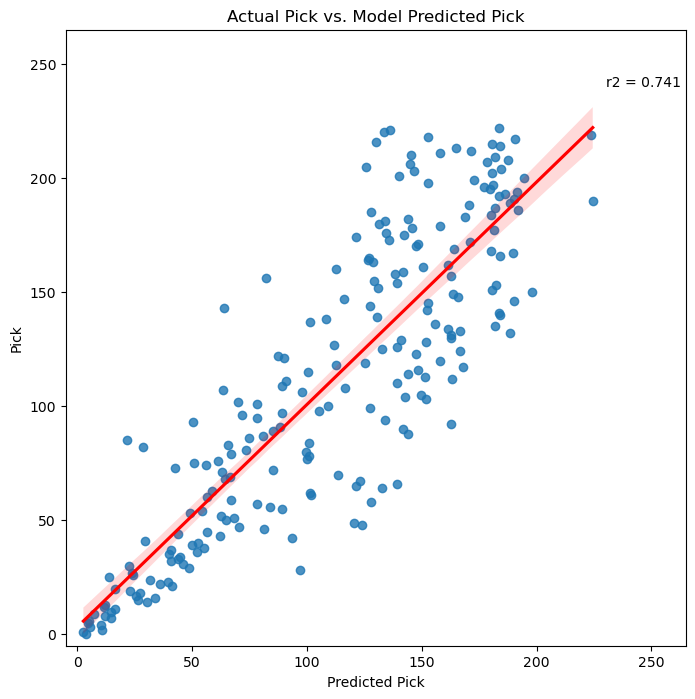

In [61]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_forest,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(-5,265)
plt.ylim(-5,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_forest),3)}',xy=(230,240));

In [26]:
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Liberty League',
       'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain East Conference', 'x0_Mountain West Conference',
       'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic 

In [27]:
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [28]:
feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
 'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference','x0_None','speed_col',
 'shuttle_agility_col',
 'cone_agility_col','x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR','2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [29]:
weights = rfc_pipe[-1].feature_importances_

In [30]:
coefs = pd.DataFrame(zip(feature_cols,weights))

In [31]:
coefs.sort_values(by=1,ascending=False).head(20)

,0,1
3,ovr_rk_col,0.584544
4,grade_col,0.114419
6,reportlen_col,0.008754
2,pos_rk_col,0.006718
84,x0_Atlantic Coast Conference,0.005163
0,weight_x_col,0.004690
7,forty_yd_col,0.004502
1,height_x_col,0.004100
230,lack,0.003673
86,x0_Big Sky Conference,0.003442


In [62]:
results = pd.concat([player_name.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred_forest),pd.Series(y_test)],axis=1)

In [63]:
mock_draft_year = results.sort_values(by=0)

In [64]:
results.sort_values(by=1)

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,3986,Travon Walker,3986,1,3986,2022.0,3986,NaN,NaN,2.0,...,0.0,0.152599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.967077,0
1,3987,Aidan Hutchinson,3987,1,3987,2022.0,3987,NaN,NaN,1.0,...,0.0,0.000000,0.184801,0.206629,0.000000,0.000000,0.000000,0.000000,2.606218,1
2,3988,Derek Stingley,3988,1,3988,2022.0,3988,NaN,NaN,2.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.820914,2
3,3989,Sauce Gardner,3989,1,3989,2022.0,3989,NaN,NaN,1.0,...,0.0,0.000000,0.000000,0.000000,0.161050,0.000000,0.000000,0.000000,5.578466,3
4,3990,Kayvon Thibodeaux,3990,1,3990,2022.0,3990,NaN,NaN,3.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.313113,4
5,3991,Ikem Ekwonu,3991,1,3991,2022.0,3991,NaN,NaN,1.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.412540,5
6,3992,Evan Neal,3992,1,3992,2022.0,3992,NaN,NaN,2.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.219273,4.906779,6
7,3993,Drake London,3993,1,3993,2022.0,3993,NaN,NaN,2.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.525131,14.483562,7
8,3994,Charles Cross,3994,1,3994,2022.0,3994,NaN,NaN,3.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.153659,0.220610,0.221295,11.886958,8
9,3995,Garrett Wilson,3995,1,3995,2022.0,3995,NaN,NaN,1.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.385085,9


In [65]:
mock_draft_year

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
1,3987,Aidan Hutchinson,3987,1,3987,2022.0,3987,NaN,NaN,1.0,...,0.0,0.000000,0.184801,0.206629,0.000000,0.000000,0.000000,0.000000,2.606218,1
0,3986,Travon Walker,3986,1,3986,2022.0,3986,NaN,NaN,2.0,...,0.0,0.152599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.967077,0
5,3991,Ikem Ekwonu,3991,1,3991,2022.0,3991,NaN,NaN,1.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.412540,5
6,3992,Evan Neal,3992,1,3992,2022.0,3992,NaN,NaN,2.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.219273,4.906779,6
3,3989,Sauce Gardner,3989,1,3989,2022.0,3989,NaN,NaN,1.0,...,0.0,0.000000,0.000000,0.000000,0.161050,0.000000,0.000000,0.000000,5.578466,3
9,3995,Garrett Wilson,3995,1,3995,2022.0,3995,NaN,NaN,1.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.385085,9
4,3990,Kayvon Thibodeaux,3990,1,3990,2022.0,3990,NaN,NaN,3.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.313113,4
2,3988,Derek Stingley,3988,1,3988,2022.0,3988,NaN,NaN,2.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.820914,2
12,3998,Jordan Davis,3998,1,3998,2022.0,3998,NaN,NaN,1.0,...,0.0,0.000000,0.000000,0.000000,0.205251,0.000000,0.000000,0.000000,11.672109,12
8,3994,Charles Cross,3994,1,3994,2022.0,3994,NaN,NaN,3.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.153659,0.220610,0.221295,11.886958,8


In [66]:
mock_draft_year['Actual_Pick'] = mock_draft_year[1] + 1

In [67]:
mock_draft_year

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,versatil,well,work,yard,year,year starter,zone,0,1,Actual_Pick
1,3987,Aidan Hutchinson,3987,1,3987,2022.0,3987,NaN,NaN,1.0,...,0.000000,0.184801,0.206629,0.000000,0.000000,0.000000,0.000000,2.606218,1,2
0,3986,Travon Walker,3986,1,3986,2022.0,3986,NaN,NaN,2.0,...,0.152599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.967077,0,1
5,3991,Ikem Ekwonu,3991,1,3991,2022.0,3991,NaN,NaN,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.412540,5,6
6,3992,Evan Neal,3992,1,3992,2022.0,3992,NaN,NaN,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.219273,4.906779,6,7
3,3989,Sauce Gardner,3989,1,3989,2022.0,3989,NaN,NaN,1.0,...,0.000000,0.000000,0.000000,0.161050,0.000000,0.000000,0.000000,5.578466,3,4
9,3995,Garrett Wilson,3995,1,3995,2022.0,3995,NaN,NaN,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.385085,9,10
4,3990,Kayvon Thibodeaux,3990,1,3990,2022.0,3990,NaN,NaN,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.313113,4,5
2,3988,Derek Stingley,3988,1,3988,2022.0,3988,NaN,NaN,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.820914,2,3
12,3998,Jordan Davis,3998,1,3998,2022.0,3998,NaN,NaN,1.0,...,0.000000,0.000000,0.000000,0.205251,0.000000,0.000000,0.000000,11.672109,12,13
8,3994,Charles Cross,3994,1,3994,2022.0,3994,NaN,NaN,3.0,...,0.000000,0.000000,0.000000,0.000000,0.153659,0.220610,0.221295,11.886958,8,9


In [68]:
mock_draft_year['Diff'] = (mock_draft_year[0] - mock_draft_year.Actual_Pick).abs() 

In [69]:
mock = mock_draft_year[['player_col','Round_col', 'Actual_Pick',0,'Diff']].reset_index()

In [70]:
mock[['player_col','Round_col', 'Actual_Pick',0,'Diff']].head(32)

,player_col,Round_col,Actual_Pick,0,Diff
0,Aidan Hutchinson,1,2,2.606218,0.606218
1,Travon Walker,1,1,3.967077,2.967077
2,Ikem Ekwonu,1,6,4.412540,1.587460
3,Evan Neal,1,7,4.906779,2.093221
4,Sauce Gardner,1,4,5.578466,1.578466
5,Garrett Wilson,1,10,7.385085,2.614915
6,Kayvon Thibodeaux,1,5,10.313113,5.313113
7,Derek Stingley,1,3,10.820914,7.820914
8,Jordan Davis,1,13,11.672109,1.327891
9,Charles Cross,1,9,11.886958,2.886958


In [41]:
pd.set_option("display.max_rows", None)
mock_draft_year.head(32)

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,Actual_Pick,Diff
0,3727,Trevor Lawrence,3727,1,3727,2021.0,3727,213.0,77.625,1.0,...,0.246131,0.137602,0.000000,0.000000,0.000000,0.000000,1.833385,0,1,0.833385
3,3730,Kyle Pitts,3730,1,3730,2021.0,3730,245.0,77.625,1.0,...,0.000000,0.122153,0.000000,0.000000,0.000000,0.132933,2.318889,3,4,1.681111
1,3728,Zach Wilson,3728,1,3728,2021.0,3728,214.0,74.125,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.157323,4.457381,1,2,2.457381
4,3731,Ja'Marr Chase,3731,1,3731,2021.0,3731,201.0,72.375,1.0,...,0.000000,0.000000,0.153093,0.000000,0.000000,0.000000,5.034703,4,5,0.034703
9,3736,DeVonta Smith,3736,1,3736,2021.0,3736,170.0,72.250,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.167490,6.563915,9,10,3.436085
6,3733,Penei Sewell,3733,1,3733,2021.0,3733,331.0,76.875,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.203487,7.196944,6,7,0.196944
10,3737,Justin Fields,3737,1,3737,2021.0,3737,227.0,74.750,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.727959,10,11,2.272041
5,3732,Jaylen Waddle,3732,1,3732,2021.0,3732,180.0,69.500,3.0,...,0.185384,0.207281,0.000000,0.000000,0.000000,0.000000,8.932009,5,6,2.932009
2,3729,Trey Lance,3729,1,3729,2021.0,3729,224.0,75.875,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.765572,2,3,6.765572
14,3741,Mac Jones,3741,1,3741,2021.0,3741,217.0,74.625,5.0,...,0.000000,0.000000,0.159100,0.000000,0.000000,0.000000,9.946833,14,15,5.053167


In [42]:
results['difference'] = results[0] - results[1]
results['abs_difference'] = (results[0] - results[1]).abs()

In [43]:
results.difference

0        1.833385
1        3.457381
2        7.765572
3       -0.681111
4        1.034703
5        3.932009
6        1.196944
7        6.004100
8        3.330214
9       -2.436085
10      -1.272041
11       7.313281
12       2.314883
13       1.906210
14      -4.053167
15      16.089365
16      51.188917
17       9.650194
18       8.113347
19      17.029094
20       4.633309
21       4.774717
22       6.289100
23      12.349336
24       4.043818
25       2.500095
26       6.102972
27      53.997244
28      51.873292
29      20.523347
30      18.928380
31      12.366717
32      14.759766
33      -7.907085
34       7.297004
35      26.511560
36      10.175590
37       2.896464
38     -14.305663
39      17.420665
40      10.910526
41     -12.629983
42     -19.248484
43      42.941133
44      26.890340
45      41.858434
46      -3.063636
47      37.450443
48      11.014788
49     -17.604993
50      30.069622
51     -38.229384
52      -3.179193
53      82.021217
54       4.054537
55       9

In [44]:
results.abs_difference.mean()

33.04109095266513

<AxesSubplot:xlabel='abs_difference', ylabel='Count'>

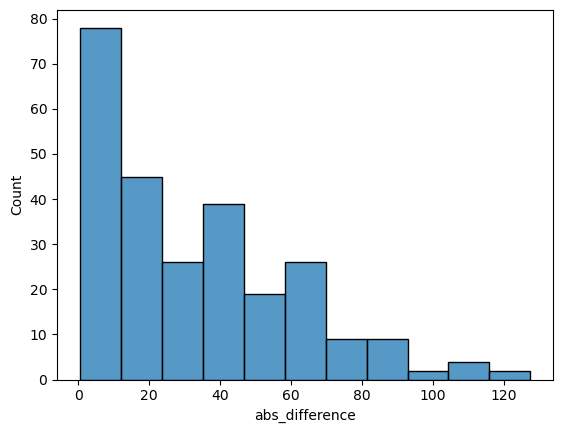

In [45]:
sns.histplot(results.abs_difference);

In [46]:
best = results[results.abs_difference <= 16]

In [47]:
best

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
0,3727,Trevor Lawrence,3727,1,3727,2021.0,3727,213.0,77.625,1.0,...,0.246131,0.137602,0.000000,0.000000,0.000000,0.000000,1.833385,0,1.833385,1.833385
1,3728,Zach Wilson,3728,1,3728,2021.0,3728,214.0,74.125,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.157323,4.457381,1,3.457381,3.457381
2,3729,Trey Lance,3729,1,3729,2021.0,3729,224.0,75.875,3.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.765572,2,7.765572,7.765572
3,3730,Kyle Pitts,3730,1,3730,2021.0,3730,245.0,77.625,1.0,...,0.000000,0.122153,0.000000,0.000000,0.000000,0.132933,2.318889,3,-0.681111,0.681111
4,3731,Ja'Marr Chase,3731,1,3731,2021.0,3731,201.0,72.375,1.0,...,0.000000,0.000000,0.153093,0.000000,0.000000,0.000000,5.034703,4,1.034703,1.034703
5,3732,Jaylen Waddle,3732,1,3732,2021.0,3732,180.0,69.500,3.0,...,0.185384,0.207281,0.000000,0.000000,0.000000,0.000000,8.932009,5,3.932009,3.932009
6,3733,Penei Sewell,3733,1,3733,2021.0,3733,331.0,76.875,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.203487,7.196944,6,1.196944,1.196944
7,3734,Jaycee Horn,3734,1,3734,2021.0,3734,205.0,72.750,2.0,...,0.119799,0.000000,0.000000,0.000000,0.000000,0.000000,13.004100,7,6.004100,6.004100
8,3735,Pat Surtain II,3735,1,3735,2021.0,3735,208.0,74.000,1.0,...,0.000000,0.000000,0.209267,0.000000,0.000000,0.000000,11.330214,8,3.330214,3.330214
9,3736,DeVonta Smith,3736,1,3736,2021.0,3736,170.0,72.250,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.167490,6.563915,9,-2.436085,2.436085


In [48]:
worst = results[results.abs_difference >= 64]

In [49]:
best.Round_col.value_counts(normalize=True)

1    0.263158
2    0.189474
5    0.189474
4    0.147368
3    0.115789
6    0.073684
7    0.021053
Name: Round_col, dtype: Float64

In [50]:
worst.Round_col.value_counts(normalize=True)

7    0.368421
3    0.263158
6    0.184211
4    0.105263
2    0.052632
5    0.026316
Name: Round_col, dtype: Float64

In [51]:
best_pos = best.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)
worst_pos = worst.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

In [52]:
best_pos.sort_values(ascending=False)

QB    0.035074
RB    0.031904
DT    0.025605
WR    0.012233
DL    0.009795
FB    0.006665
LS    0.002804
CB    0.000325
TE   -0.000366
S    -0.007031
OL   -0.009185
LB   -0.012315
DB   -0.042146
DE   -0.045641
K          NaN
P          NaN
Name: pos_col, dtype: float64

In [53]:
worst_pos.sort_values(ascending=False)

DB    0.068380
DE    0.054359
CB    0.031904
OL    0.006604
RB    0.005588
WR   -0.003556
DL   -0.005995
S    -0.012294
LB   -0.017578
DT         NaN
FB         NaN
K          NaN
LS         NaN
P          NaN
QB         NaN
TE         NaN
Name: pos_col, dtype: float64

In [54]:
results.pos_col.value_counts(normalize=True)

OL    0.177606
WR    0.135135
DB    0.115830
LB    0.096525
DL    0.084942
DE    0.077220
CB    0.073359
RB    0.073359
TE    0.042471
QB    0.038610
S     0.038610
DT    0.027027
LS    0.007722
K     0.003861
FB    0.003861
P     0.003861
Name: pos_col, dtype: float64

In [55]:
best.pos_col.value_counts(normalize=True)

OL    0.168421
WR    0.147368
RB    0.105263
DL    0.094737
LB    0.084211
QB    0.073684
DB    0.073684
CB    0.073684
DT    0.052632
TE    0.042105
DE    0.031579
S     0.031579
FB    0.010526
LS    0.010526
Name: pos_col, dtype: float64

In [56]:
worst.pos_col.value_counts(normalize=True)

OL    0.184211
DB    0.184211
WR    0.131579
DE    0.131579
CB    0.105263
DL    0.078947
LB    0.078947
RB    0.078947
S     0.026316
Name: pos_col, dtype: float64

<AxesSubplot:xlabel='abs_difference', ylabel='Count'>

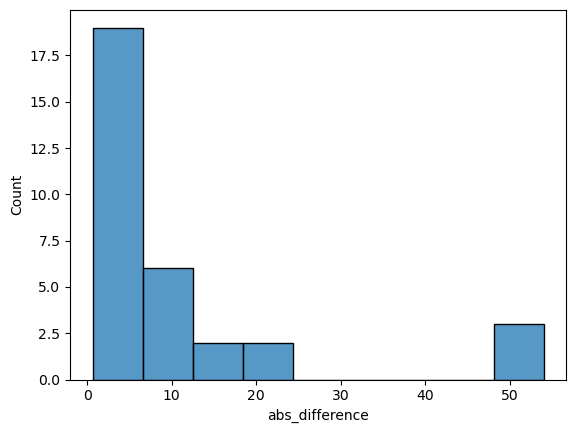

In [57]:
sns.histplot(results[results.Round_col == 1].abs_difference)

In [ ]:
miss_one = one_round[one_round.abs_difference > 32]

In [ ]:
miss_one.develop.mean()

In [ ]:
one_round.develop.mean()

In [ ]:
results[results.Round_col == 2].abs_difference.mean()

In [ ]:
results[results.Round_col == 3].abs_difference.mean()

In [ ]:
results[results.Round_col == 4].abs_difference.mean()

In [ ]:
results[results.Round_col == 5].abs_difference.mean()

In [ ]:
results[results.Round_col == 6].abs_difference.mean()

In [ ]:
results[results.Round_col == 7].abs_difference.mean()